# Tutorial 5: Engine-specific implementation

In this tutorial, we will discuss how to add an [engine-specific implementation](https://eagerx.readthedocs.io/en/master/guide/api_reference/object/index.html#eagerx.core.entities.Object.example_engine)
for an object.

The following will be covered:
- Adding an [engine-specific implementation](https://eagerx.readthedocs.io/en/master/guide/api_reference/object/index.html#eagerx.core.entities.Object.example_engine)
- Initializing the corresponding [engine](https://eagerx.readthedocs.io/en/master/guide/api_reference/engine/index.html)
- Train with the newly added [engine-specific implementation](https://eagerx.readthedocs.io/en/master/guide/api_reference/object/index.html#eagerx.core.entities.Object.example_engine)

In the remainder of this tutorial we will go more into detail on this concept.

Furthermore, at the end of this notebook you will find an exercise.
For the exercise you will have to add/modify a couple of lines of code, which are marked by

```python

# START EXERCISE [BLOCK_NUMBER]

# END EXERCISE [BLOCK_NUMBER]
```

## Pendulum Swing-up

We will assume that we already have the object definition of the underactuated pendulum that we used in the [first](https://colab.research.google.com/github/eager-dev/eagerx_tutorials/blob/master/tutorials/pendulum/1_environment_creation.ipynb) tutorial with its dynamics simulated by the ODE engine and corresponding ordinary differential equations (ODEs).

Our goal is to interface the underactuated pendulum we used in the previous tutorials with a different physics-engine. This allows us to investigate the effect of the physics engine on the learned performance.

## Activate GPU (Colab only)

When in Colab, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

In [1]:
#@title Notebook Setup

#@markdown In order to be able to run the code, we need to install the *eagerx_tutorials* package.

try:
    import eagerx_tutorials
except ImportError:
    if "google.colab" in str(get_ipython()):
        print("Installing pybullet with pip.")
        import gdown
        gdown.download(id="15IKv71tEK11p1B6iZ1HX8r_MY2ibcS_h", quiet=True)
        !pip install pybullet-3.2.5-cp310-cp310-linux_x86_64.whl >> /tmp/pybullet_install.txt 2>&1
    !{"echo 'Installing eagerx-tutorials with pip.' && pip install eagerx-tutorials >> /tmp/eagerx_install.txt 2>&1"}

# Setup interactive notebook
# Required in interactive notebooks only.
from eagerx_tutorials import helper
helper.setup_notebook()

# Import eagerx
import eagerx
eagerx.set_log_level(eagerx.WARN)

Not running on CoLab.


## Let's get started

We will again create an environment with the *Pendulum* object, like we did in the [first](https://colab.research.google.com/github/eager-dev/eagerx_tutorials/blob/master/tutorials/pendulum/1_environment_creation.ipynb) and [second](https://colab.research.google.com/github/eager-dev/eagerx_tutorials/blob/master/tutorials/pendulum/2_reset_and_step.ipynb) tutorials.

Let's make the *Pendulum* object and add it to an empty graph.

In [2]:
# Make the pendulum
from eagerx_tutorials.pendulum.objects import Pendulum
# START EXERCISE 1.3.a
# Add "u_applied" to the sensors.
pendulum = Pendulum.make("pendulum", actuators=["u"], sensors=["theta", "theta_dot", "image"], states=["model_state"])
# END EXERCISE 1.3.a

# Define rate in Hz
rate = 30.0

# Initialize empty graph
graph = eagerx.Graph.create()

# Add pendulum to the graph
graph.add(pendulum)

# Connect the pendulum to an action and observation
graph.connect(action="voltage", target=pendulum.actuators.u)
graph.connect(source=pendulum.sensors.theta, observation="angle")
graph.connect(source=pendulum.sensors.theta_dot, observation="angular_velocity")
# START EXERCISE 1.3.b
# Connect sensor u_applied to an observation.

# END EXERCISE 1.3.b

# Render image
graph.render(source=pendulum.sensors.image, rate=rate)

In the preceding tutorials, we simulated the pendulum dynamics with a set of ordinary differential equations (ODE). In other words, the ODEs acted as the physics-engine. However, in robotics we are ultimately interested in how our learned controller performs in the real-world. EAGERx views the real-world as just another physics-engine. Ideally, we would only want to swap-out those components that are specific to the ODE physics-engine with the real-world specific components. In this way, all other (agnostic) components, such as controllers, are exactly the same in both setups, thus minimizing the differences between our real-world experiments and ODE simulation.

In EAGERx, this is achieved by grouping the physics-engine specific components of an object into *engine-specific implementations*. The implementation is then registered to the engine that corresponds to the interfaced physics-engine.

Thus, an object in EAGERx will have a **single** agnostic definition of the sensors, actuators, and states, but may have **multiple** *engine-specific implementations* for each physics-engine. This implementation then defines how the sensors, actuators, and states are simulated using a specified engine that, in turn, corresponds to a physics-engine (e.g. Pybullet, real-world, Gazebo, ...).

Lets start by printing info on the pendulum.

In [3]:
Pendulum.info()

   entity_type: `Pendulum`
   module: `eagerx_tutorials.pendulum.objects`
   file: `/home/jelle/eagerx_dev/eagerx_tutorials/eagerx_tutorials/pendulum/objects.py`

Supported engines:
 - eagerx_ode.engine/OdeEngine

Make this spec with:
   spec = Pendulum.make(name: str, actuators: List[str] = None, sensors: List[str] = None, states: List[str] = None, rate: float = 30.0, render_shape: List[int] = None, render_fn: str = None)

class Pendulum:
   make(name: str, actuators: List[str] = None, sensors: List[str] = None, states: List[str] = None, rate: float = 30.0, render_shape: List[int] = None, render_fn: str = None):
      sensors:
       - theta: Space(-999.0, 999.0, (), float32)
       - theta_dot: Space(-999.0, 999.0, (), float32)
       - image: Space(uint8)
       - u_applied: Space([-2.], [2.], (1,), float32)
      actuators:
       - u: Space([-2.], [2.], (1,), float32)
      engine_states:
       - model_state: Space([-3.14 -9.  ], [3.14 9.  ], (2,), float32)
       - model_paramet

The printed info shows, amongst other things, the supported engines of the *Pendulum*. Currently, only the [OdeEngine](https://github.com/eager-dev/eagerx_ode/blob/master/eagerx_ode/engine.py) is supported. 

In the exercise of this tutorial, we will finish the code below. This will add support for a physics-engine that is interfaced by the [GymEngine](https://github.com/eager-dev/eagerx/blob/master/eagerx/engines/openai_gym/engine.py). Basically, the physics-engine is the [Pendulum-v1](https://www.gymlibrary.ml/environments/classic_control/pendulum/) environment and it uses the dynamics of the [Pendulum-v1](https://www.gymlibrary.ml/environments/classic_control/pendulum/) environment to simulate our pendulum.

In essence, an *engine-specific* implementation must do the following:
- Set any engine-specific parameters that are required by the engine to add an object to the physics-engine. These correspond to the arguments (excluding `spec`) of the engine's [engine.add_object](https://eagerx.readthedocs.io/en/master/guide/api_reference/engine/index.html#eagerx.core.entities.Engine.add_object) method. In the example below, we need to set the engine-specific parameter `env_id` to the id of the pendulum environment. You can get info on all the engine-parameters with `GymEngine.info("add_object")` under the `add_object` section.
- Make [EngineNodes](https://eagerx.readthedocs.io/en/master/guide/api_reference/node/engine_node.html) and connect them in the [EngineGraph](https://eagerx.readthedocs.io/en/master/guide/api_reference/graph/engine_graph.html) to the object's registered sensors and actuators. It is not compulsory to connect all registered sensors and actuators. Hence, you may only implement a subset of them. In this example, we do not connect the registered sensor `u_applied`, which is not a problem as long as we do not select it at run-time.
- Make [EngineStates](https://eagerx.readthedocs.io/en/master/guide/api_reference/engine_state/index.html) and set them to the object's registered states. In this example, we use dummy states, because OpenAI gym environments do not have a uniform API to set environment states. See the engine-implementation of the OdeEngine [here](https://github.com/eager-dev/eagerx_tutorials/blob/3ddc2eb7558c7825095611fec3a01a47f5e7af79/eagerx_tutorials/pendulum/objects.py#L108-L168) for a non-trivial example with engine states.


In [4]:
from eagerx import register
from eagerx.engines.openai_gym.engine import GymEngine


GymEngine.info("add_object")


# This decorator registers the engine-specific implementation for the Pendulum object.
@register.engine(GymEngine, entity=Pendulum)
def gym_engine(spec: eagerx.specs.ObjectSpec, graph: eagerx.EngineGraph):
    """Engine-specific implementation (GymEngine) of the Pendulum object."""
    
    # Import the openai engine-specific nodes (ObservationSensor, ActionActuator, GymImage)
    from eagerx.engines.openai_gym.enginenodes import ObservationSensor, ActionActuator, GymImage

    # Import the tutorial engine-specific nodes (FloatOutput)
    from eagerx_tutorials.pendulum.engine_nodes import FloatOutput

    # Set engine-specific parameters
    spec.engine.env_id = "Pendulum-v1"
    
    # Create engine states that implement the registered states
    # Note: The GymEngine implementation unfortunately does not support setting the OpenAI environment state,
    #       nor does it support changing the dynamic parameters.
    #       However, you could create an Engine specifically for the Pendulum-v1 environment.
    from eagerx_tutorials.pendulum.engine_states import DummyState, SetGymAttribute
    spec.engine.states.model_state = DummyState.make()  # Use dummy state, so it can still be selected.
    spec.engine.states.model_parameters = DummyState.make()  # Use dummy state (same reason as above).
    spec.engine.states.mass = SetGymAttribute.make(attribute="m")
    spec.engine.states.length = SetGymAttribute.make(attribute="l")
    spec.engine.states.max_speed = SetGymAttribute.make(attribute="max_speed")

    # Create sensor engine nodes.
    image = GymImage.make("image", rate=spec.sensors.image.rate, shape=spec.config.render_shape, process=2)
    theta = FloatOutput.make("theta", rate=spec.sensors.theta.rate, idx=0)
    # Create engine node that implements the theta_dot observation
    # START EXERCISE 1.1.a

    # END EXERCISE 1.1.a

    # Create actuator engine node
    action = ActionActuator.make("action", rate=spec.actuators.u.rate, process=2, zero_action=[0])

    # Use the observations produced by the "Pendulum-v1" to obtain theta and theta_dot.
    # Because this observation is [sin(theta), cos(theta), theta_dot], so we first convert it to [theta, theta_dot]
    x = ObservationSensor.make("x", rate=spec.sensors.theta.rate, process=2)
    from eagerx_tutorials.pendulum.processor import DecomposedAngle
    x.outputs.observation.processor = DecomposedAngle.make(convert_to="theta_theta_dot")

    # Add all engine nodes to the engine-specific graph
    graph.add([x, theta, image, action])
    # START EXERCISE 1.1.b

    # END EXERCISE 1.1.b

    # theta
    graph.connect(source=x.outputs.observation, target=theta.inputs.observation_array)
    graph.connect(source=theta.outputs.observation, sensor="theta")

    # theta_dot
    # START EXERCISE 1.1.c

    # END EXERCISE 1.1.c

    # image
    graph.connect(source=image.outputs.image, sensor="image")

    # u
    # Note: not to be confused with sensor "u", for which we do not provide an implementation here.
    # Note: We add a processor that negates the action, as the torque in OpenAI gym is defined counter-clockwise.
    from eagerx_tutorials.pendulum.processor import VoltageToMotorTorque
    action.inputs.action.processor = VoltageToMotorTorque.make(K=0.03333, R=7.731)
    graph.connect(actuator="u", target=action.inputs.action)

   entity_type: `GymEngine`
   module: `eagerx.engines.openai_gym.engine`
   file: `/home/jelle/.cache/pypoetry/virtualenvs/eagerx-tutorials-NkxrhtGC-py3.8/lib/python3.8/site-packages/eagerx/engines/openai_gym/engine.py`

Make this spec with:
   spec = GymEngine.make(rate, process: Union[int, NoneType] = 0, sync: Union[bool, NoneType] = True, real_time_factor: Union[float, NoneType] = 0, simulate_delays: Union[bool, NoneType] = True, log_level: Union[int, NoneType] = 40)

class GymEngine:
   add_object(self, name: str, env_id: str, seed: int = None):
      engine_config: <Nothing registered>
      docs:

                 Adds an object whose dynamics are governed by a registered OpenAI gym environment.

                 :param name: Name of the :class:`~eagerx.core.entities.Object` that is to be added.
                 :param env_id: Gym id of the environment.
                 :param seed: Seed for the environment.
        




After defining the engine-specific implementation for the GymEngine and registering it, we again print info on the pendulum. 

Now we see that the GymEngine **is** supported:

In [5]:
Pendulum.info()

   entity_type: `Pendulum`
   module: `eagerx_tutorials.pendulum.objects`
   file: `/home/jelle/eagerx_dev/eagerx_tutorials/eagerx_tutorials/pendulum/objects.py`

Supported engines:
 - eagerx_ode.engine/OdeEngine
 - eagerx.engines.openai_gym.engine/GymEngine

Make this spec with:
   spec = Pendulum.make(name: str, actuators: List[str] = None, sensors: List[str] = None, states: List[str] = None, rate: float = 30.0, render_shape: List[int] = None, render_fn: str = None)

class Pendulum:
   make(name: str, actuators: List[str] = None, sensors: List[str] = None, states: List[str] = None, rate: float = 30.0, render_shape: List[int] = None, render_fn: str = None):
      sensors:
       - theta: Space(-999.0, 999.0, (), float32)
       - theta_dot: Space(-999.0, 999.0, (), float32)
       - image: Space(uint8)
       - u_applied: Space([-2.], [2.], (1,), float32)
      actuators:
       - u: Space([-2.], [2.], (1,), float32)
      engine_states:
       - model_state: Space([-3.14 -9.  ], [3.1

We will start by using the OdeEngine similar to the previous tutorials. Later on in the exercises. we will switch and use the [GymEngine](https://github.com/eager-dev/eagerx/blob/master/eagerx/engines/openai_gym/engine.py) instead.

In [6]:
# Import the two supported engines
from eagerx_ode.engine import OdeEngine
from eagerx.engines.openai_gym.engine import GymEngine

# Make the engine
# START EXERCISE 1.2 & 1.5
engine = OdeEngine.make(rate=rate)
# engine = GymEngine.make(rate=rate, process=eagerx.ENVIRONMENT)
# END EXERCISE 1.2 & 1.5

At this point, we have created a graph containing the pendulum. We provide the graph to the environment together with the engine. Based on this engine, we will initialize the *engine-specific implementation* that was registered with this engine. 
- If the [OdeEngine](https://github.com/eager-dev/eagerx_ode) is provided, we use the registered OdeEngine implementation [here](https://github.com/eager-dev/eagerx_tutorials/blob/3ddc2eb7558c7825095611fec3a01a47f5e7af79/eagerx_tutorials/pendulum/objects.py#L108-L168).
- If the [GymEngine](https://github.com/eager-dev/eagerx/blob/master/eagerx/engines/openai_gym/engine.py) is provided, we will use the registered implementation above.
- If we would have an implemention for the real-world and registered it with the [RealEngine](https://github.com/eager-dev/eagerx_reality/blob/m1aster/eagerx_reality/engine.py), it would be selected when we choose the [RealEngine](https://github.com/eager-dev/eagerx_reality/blob/m1aster/eagerx_reality/engine.py).

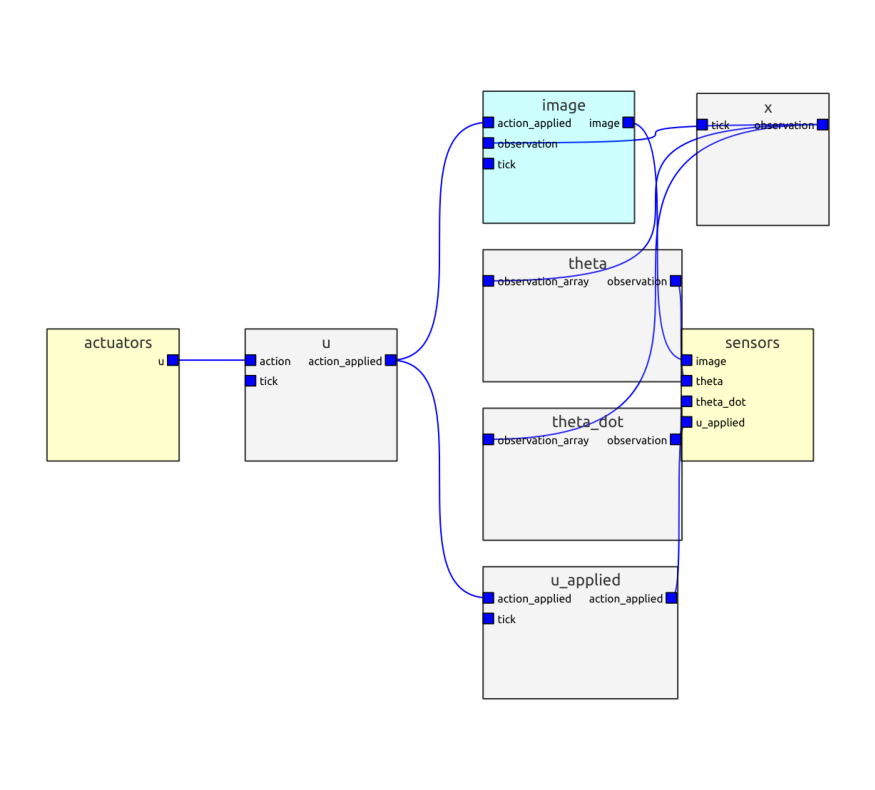

In [7]:
#@markdown Using the [*eagerx_gui* package](https://github.com/eager-dev/eagerx_gui), we can visualize the engine graphs for the *OdeEngine*.

%matplotlib inline
from matplotlib import pyplot as plt

ode_render = pendulum.gui(OdeEngine, interactive=False)
plt.rcParams['figure.figsize'] = [15, 10]
plt.axis("off")
plt.imshow(ode_render)

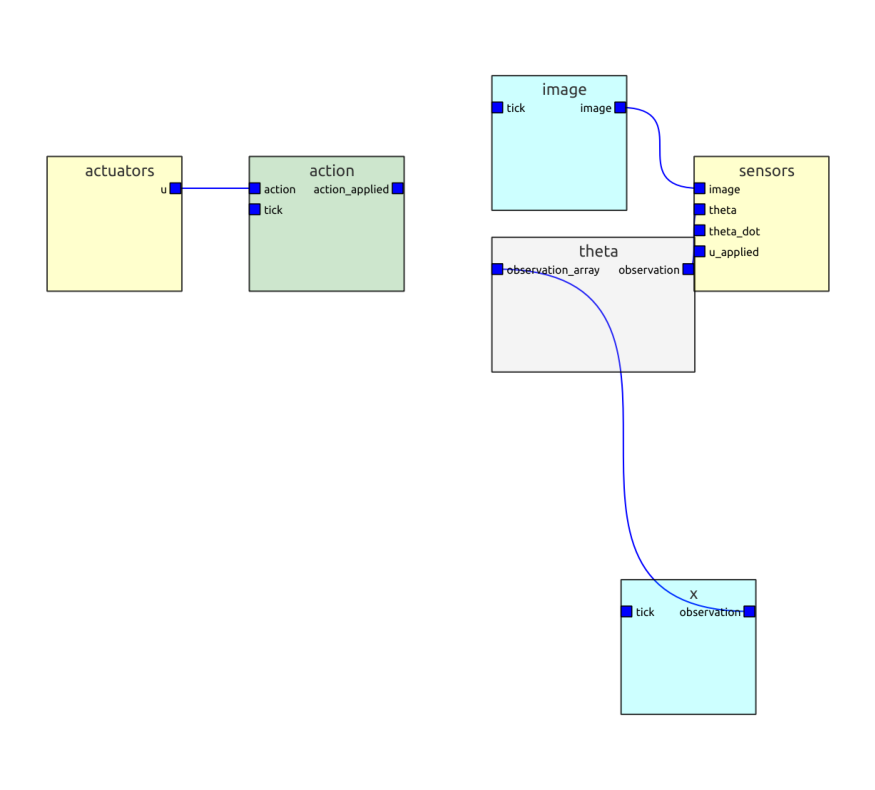

In [8]:
#@markdown And for the *GymEngine*.

%matplotlib inline

gym_render = pendulum.gui(GymEngine, interactive=False)
plt.rcParams['figure.figsize'] = [15, 10]
plt.axis("off")
plt.imshow(gym_render)

In [9]:
#@markdown We will define the environment and create it like we did in the previous tutorials.

from typing import Dict
import numpy as np


class PendulumEnv(eagerx.BaseEnv):
    def __init__(self, name: str, rate: float, graph: eagerx.Graph, engine: eagerx.Engine, render_mode="human"):
        """Initializes an environment with EAGERx dynamics.

        :param name: The name of the environment. Everything related to this environment
                     (parameters, topics, nodes, etc...) will be registered under namespace: "/[name]".
        :param rate: The rate (Hz) at which the environment will run.
        :param graph: The graph consisting of nodes and objects that describe the environment's dynamics.
        :param engine: The physics engine that will govern the environment's dynamics.
        :param render_mode: Defines the render mode (e.g. "human", "rgb_array").
        """
        # Make the backend specification
        from eagerx.backends.single_process import SingleProcess
        backend = SingleProcess.make()
        
        self.eval = eval
        
        # Maximum episode length
        self.max_steps = 100
        
        # Step counter
        self.steps = None
        super().__init__(name, rate, graph, engine, backend, force_start=True, render_mode=render_mode)
    
    def step(self, action: Dict):
        """A method that runs one timestep of the environment's dynamics.

        :params action: A dictionary of actions provided by the agent.
        :returns: A tuple (observation, reward, terminated, truncated, info).

              - observation: Observations of the current timestep that comply with
                             the :func:`~eagerx.core.env.BaseEnv.observation_space`.

              - reward: amount of reward returned after previous action

              - terminated: whether the episode has ended due to a terminal state, in which case further step() calls will
                            return undefined results

              - truncated: whether the episode has ended due to a time limit, in which case further step() calls will
                           return undefined results

              - info: contains auxiliary diagnostic information (helpful for debugging, and sometimes learning)
        """
        # Take step
        observation = self._step(action)
        self.steps += 1
        
        # Get angle and angular velocity
        # Take first element because of window size (covered in other tutorial)
        th = observation["angle"][0]
        thdot = observation["angular_velocity"][0]

        # Convert from numpy array to float
        u = float(action["voltage"])

        # Calculate cost
        # Penalize angle error, angular velocity and input voltage
        cost = th**2 + 0.1 * (thdot / (1 + 10 * abs(th))) ** 2 + 0.01 * u ** 2  

        # Determine when is the episode over
        # currently just a timeout after 100 steps
        terminated = False
        truncated = self.steps > self.max_steps
        info = {}

        # Render
        if self.render_mode == "human":
            self.render()
        return observation, -cost, terminated, truncated, info
    
    def reset(self, seed=None, options=None):
        """Resets the environment to an initial state and returns an initial observation.

        :returns: The initial observation.
        """
        # Determine reset states
        states = self.state_space.sample()
            
        # Perform reset
        observation = self._reset(states)
        info = {}

        # Reset step counter
        self.steps = 0
        
        # Render
        if self.render_mode == "human":
            self.render()
        return observation, info
    
# Initialize Environment
env = PendulumEnv(name="PendulumEnv", rate=rate, graph=graph, engine=engine)

# Print action & observation space
print("action_space: ", env.action_space)
print("observation_space: ", env.observation_space)

[WARN]: Backend 'SINGLE_PROCESS' does not support multiprocessing, so all nodes are launched in the ENVIRONMENT process.
action_space:  Dict('voltage': Space([-2.], [2.], (1,), float32))
observation_space:  Dict('angle': Box(-999.0, 999.0, (1,), float32), 'angular_velocity': Box(-999.0, 999.0, (1,), float32))


In [10]:
#@title Training

#@markdown Finally, we train the agent using [Stable Baselines3](https://stable-baselines3.readthedocs.io/en/master/), again similar to the preceding tutorials.#@markdown 

import stable_baselines3 as sb3
from stable_baselines3.common.env_checker import check_env
from eagerx.wrappers import Flatten

# Stable Baselines3 expects flattened actions & observations
# Convert observation and action space from Dict() to Box(), normalize actions
env = Flatten(env)
env = helper.RescaleAction(env, min_action=-1.0, max_action=1.0)

# Check that env follows Gym API and returns expected shapes
check_env(env)

# Initialize learner
model = sb3.SAC("MlpPolicy", env, verbose=1)

# Train for 1 minute (sim time)
model.learn(total_timesteps=int(150 * rate))

env.shutdown()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 101       |
|    ep_rew_mean     | -1.03e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 72        |
|    time_elapsed    | 5         |
|    total_timesteps | 404       |
| train/             |           |
|    actor_loss      | 18.8      |
|    critic_loss     | 2.41      |
|    ent_coef        | 0.912     |
|    ent_coef_loss   | -0.15     |
|    learning_rate   | 0.0003    |
|    n_updates       | 303       |
----------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -979     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 68       |
|    time_elapsed    | 11       |
|    total_timesteps | 808      |
| tra

# Exercise

In this exercise you will add a new engine-specific implementation to the object definition of the underactuated pendulum.

For this exercise, you will need to modify or add some lines of code in the cells above.
These lines are indicated by the following comments:

```python
# START EXERCISE [BLOCK_NUMBER]

# END EXERCISE [BLOCK_NUMBER]
```

However, feel free to play with the other code as well if you are interested.
We recommend you to restart and run all code after each section (in Colab there is the option *Restart and run all* under *Runtime*).

## 1. Add support for a new physics-engine
Up until now, we have simulated the pendulum dynamics with the *engine-specific* implementation [here](https://github.com/eager-dev/eagerx_tutorials/blob/3ddc2eb7558c7825095611fec3a01a47f5e7af79/eagerx_tutorials/pendulum/objects.py#L108-L168) that was registered with the [OdeEngine](https://github.com/eager-dev/eagerx_ode).

Most informative would be an exercise where we interface a real pendulum. Unfortunately, interactive notebooks do not allow us to easily demonstrate this without forcing users to have the exact same real pendulum we have in our lab. Therefore, we will instead add an implementation for the already defined OpenAI's [GymEngine](https://github.com/eager-dev/eagerx/blob/master/eagerx/engines/openai_gym/engine.py). We created [GymEngine](https://github.com/eager-dev/eagerx/blob/master/eagerx/engines/openai_gym/engine.py) so that any [OpenAI environment](https://gym.openai.com/envs/#classic_control) could be used as the physics-engine. In this exercise we will use the dynamics of the [Pendulum-v1](https://gym.openai.com/envs/Pendulum-v0/) environment to simulate our pendulum. For this, we will make use of the already defined engine nodes [here](https://github.com/eager-dev/eagerx/blob/master/eagerx/engines/openai_gym/enginenodes.py).

Given that you've already created the engine nodes to interface the real pendulum, you can easily add an implementation for the [RealEngine](https://github.com/eager-dev/eagerx_reality/blob/m1aster/eagerx_reality/engine.py) to train with a real pendulum following the same steps. Creating [engine nodes](https://eagerx.readthedocs.io/en/master/guide/api_reference/node/engine_node.html) is very similar to creating regular nodes which was already covered in [tutorial 4](https://colab.research.google.com/github/eager-dev/eagerx_tutorials/blob/master/tutorials/pendulum/4_nodes.ipynb). 

### Add your code to the following blocks: 

1.1.a Make an EngineNode `FloatOutput` that will be used to simulated `theta_dot`. Use `idx=1` as an argument, because the angular velocity is the second entry in the processed observation array (ie `angular_velocity = obs[1]`, hence `idx=1`).
*(hint: look at the code for `theta`).*  
1.1.b Add EngineNode `theta_dot` to the engine graph. *(hint: look at the code for `theta`).*  
1.1.c Connect `theta_dot` to the corresponding sensor with `sensor=theta_dot`. *(hint: look at the code for `theta`).*  

1.2 Select the GymEngine by uncommenting the marked line. Run the code *(note: you may need to restart your kernel)*.  

1.3.a Now, select sensor `u_applied` (not to be mistaken with the actuator `u`!!) for the pendulum.  
1.3.b Connect it as an `observation`.
Run the code and observe that it fails.
As the error states, we did not provide an implementation for sensor `u_applied`.
This highlights that it is not compulsory to implement every actuator, sensor, or state that was defined by the object.
You are free to only support a subset of them. However, you **will** get an error if you try to run with one that does not have an *engine-specific* implementation for the selected engine.  

1.4 Switch back to using the OdeEngine (while still selecting sensor `u_applied`).
Run the code.
It should again run without problems, as the OdeEngine **does** have an implementation for the sensor `u_applied`.